# First Attempt at creating a technical analysis trading strategy for US Stocks

Using:
- Quandl for data source
- TALib for metrics

Based on J Li's blog - https://kylelix7.github.io/Trading-Strategy-Technical-Analysis-with-Python-TA-Lib/

## Installation and Setup

Generally only need to do this once per kernel

### Install TA-Lib

https://www.ta-lib.org/hdr_dw.html

In [ ]:
%%bash

wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz \
  && sudo tar -xzf ta-lib-0.4.0-src.tar.gz \
  && sudo rm ta-lib-0.4.0-src.tar.gz \
  && cd ta-lib/ \
  && sudo ./configure --prefix=/usr \
  && sudo make \
  && sudo make install \
  && cd ~ \
  && sudo rm -rf ta-lib/ \
  && pip install ta-lib

### Install other Packages


In [ ]:
%%bash

pip3 install panda
pip3 install pandas_datareader
pip3 install matplotlib
pip3 install scipy
pip3 install cython
# pip3 install quandl

### Try AlphaVantage


In [ ]:
import os

api_key = os.getenv("API_KEY", None)

## Approach

For a given symbol, 

* download last 52 weeks of history (to includ 52 week hi and low) from Quandl
* compute Bollinger Bands and RSI
* Visualize

Then,
if a BUY or SELL signal is indicated, make that clear.

In [513]:
from datetime import date, timedelta
# data services
import quandl

# configuration

symbol = 'V'
data_source = 'av-daily'

weeks_lookback = 52

end_date = date.today()
start_date = end_date - timedelta(weeks=weeks_lookback)


## Step 1 - Download history for the symbol

In [514]:
import pandas_datareader.data as web

def fetch_prices(symbol, data_source, start_date, end_date, api_key):
    price = web.DataReader(name=symbol, data_source=data_source, start=start_date, end=end_date, api_key=api_key)
    print(price.shape)

    price.sort_index()
    price = price.dropna()

    # rename the column header with symbol name
    price = price.rename(columns={'close': symbol})

    return price

price = fetch_prices(symbol, data_source, start_date, end_date, api_key)

(251, 5)


## Step 2 - Compute Bollinger Bands, RSI, 50 & 200 MA

In [515]:
from talib import RSI, BBANDS, SMA

def decorate_with_studies(price):
    close = price[symbol].values
    up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    rsi = RSI(close, timeperiod=14)

    price['lower'] = low
    price['mid'] = mid
    price['upper'] = up

    price['rsi'] = rsi


    price['ma200'] = SMA(close, timeperiod=200)
    price['ma50'] = SMA(close, timeperiod=50)

    # derivatives of MA50
    price['ma50-1'] = price['ma50'] - price['ma50'].shift(periods=1)

decorate_with_studies(price)
price.head()

,open,high,low,V,volume,lower,mid,upper,rsi,ma200,ma50,ma50-1
2020-11-19,207.24,208.73,205.530,207.57,5657248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-20,207.13,208.11,203.805,203.88,9654712,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-23,204.70,209.00,204.700,208.16,6107265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-24,210.85,213.82,209.400,209.68,10076115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-25,209.67,211.95,208.870,210.89,6772894,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 3 - Find BUY/SELL dates/recommendations

Where is price outside the BB and how strong is RSI signal

In [516]:
import numpy as np

def find_buy_crosses(price):
    ma_buys = (price['ma50'] > price['ma200']) & (price['ma50-1'] > 0)
    ma_buys = ma_buys ^ ma_buys.shift(periods=-1, fill_value=ma_buys[-1])
    price['ma_buys'] = ma_buys
    ma_buy_crosses = price[price['ma_buys']].index.values   

    return ma_buy_crosses

def find_sell_crosses(price):
    ma_sells = (price['ma50'] < price['ma200']) & (price['ma50-1'] < 0)
    ma_sells = ma_sells ^ ma_sells.shift(periods=-1, fill_value=ma_sells[-1])
    price['ma_sells'] = ma_sells
    ma_sell_crosses = price[price['ma_sells']].index.values

    return ma_sell_crosses

def find_bb_rsi_buys(price):
    price_buys = price[symbol] < price['lower']
    under_buys = price['rsi'] < 90
    price['buys'] = (price_buys & under_buys) #| ma_buys
    buy_dates = price[price['buys']].index.values

    return buy_dates

def find_bb_rsi_sells(price):
    price_sells = price[symbol] > price['upper']
    over_sells = price['rsi'] > 70
    price['sells'] = (price_sells & over_sells) #| ma_sells
    sell_dates = price[price['sells']].index.values

    return sell_dates

ma_buy_crosses = find_buy_crosses(price)
ma_sell_crosses = find_sell_crosses(price)
buy_dates = find_bb_rsi_buys(price)
sell_dates = find_bb_rsi_sells(price)

extract the latest buy and sell dates and make a text reccommendation

In [517]:
from datetime import datetime

def make_recommendation(buy_dates, sell_dates, end_date, lookback=90):
    recommendation = 'HOLD'
    rec_color = 'blue'
    recommendation_date = end_date
    latest_valid_recommendation = datetime.combine(end_date - timedelta(days=lookback), datetime.min.time())

    last_buy_date = datetime.strptime(buy_dates[-1], '%Y-%m-%d')
    last_sell_date = datetime.strptime(sell_dates[-1], '%Y-%m-%d')

    if (last_buy_date > last_sell_date) and (last_buy_date > latest_valid_recommendation):
        recommendation = 'BUY'
        rec_color = 'green'
        recommendation_date = last_buy_date
    elif (last_sell_date > last_buy_date) and (last_sell_date > latest_valid_recommendation):
        recommendation = 'SELL'
        rec_color = 'red'
        recommendation_date = last_sell_date

    recommendation = f"As of {recommendation_date}, {recommendation}" # {symbol}"

    return recommendation

buys = np.append(ma_buy_crosses, buy_dates)
buys.sort()
sells = np.append(ma_sell_crosses, sell_dates)
sells.sort()
recommendation = make_recommendation(buys, sell_dates, end_date) + f" for {symbol}"
print(recommendation)

As of 2021-10-29 00:00:00, BUY for V


### Step 4 - Visualize all in one!

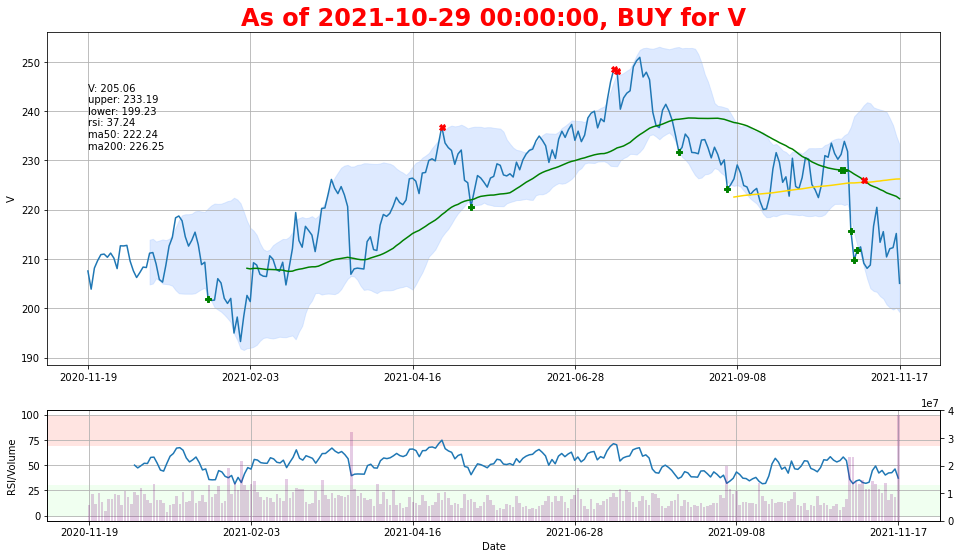

In [518]:
import matplotlib.pyplot as plt
import numpy as np
import os

def make_plot(price, recommendation, symbol):
    ma_buy_crosses = price[price['ma_buys']].index.values   
    ma_sell_crosses = price[price['ma_sells']].index.values
    buy_dates = price[price['buys']].index.values
    sell_dates = price[price['sells']].index.values

    fig, axs = plt.subplots(2, 1, figsize=(16,9), gridspec_kw={'height_ratios': [3,1]})

    xticks = [ 50*i for i in range( 0, ceil(len(price.index)/50)) ]

    axs[0].set_title(recommendation, fontdict={'fontsize': 24, 'fontweight': 'bold', 'color': rec_color})

    axs[0].plot(price.index, price[symbol])
    axs[0].set_xticks(xticks)
    axs[0].grid()
    axs[0].fill_between(price.index, price['lower'], price['upper'], color='#ADCCFF', alpha=0.4)
    axs[0].set_ylabel(symbol)

    axs[0].plot(price.index, price['ma200'], color='gold')
    axs[0].plot(price.index, price['ma50'], color='green')

    for d in ma_buy_crosses:
        axs[0].plot(d, price.loc[d]['ma50'], 'gP')
    for d in ma_sell_crosses:
        axs[0].plot(d, price.loc[d]['ma50'], 'rX')

    for d in buy_dates:
        axs[0].plot(d, price.loc[d][symbol], 'gP')
    for d in sell_dates:
        axs[0].plot(d, price.loc[d][symbol], 'rX')

    axs[1].set_xticks(axs[0].get_xticks())
    axs[1].set_xlabel('Date')
    axs[1].grid()
    axs[1].axhspan(70, 100, color='mistyrose')
    axs[1].axhspan(0, 30, color='honeydew')

    axs[1].set_ylabel('RSI/Volume')

    axs[1].plot(price.index, price['rsi'])

    ax1 = axs[1].twinx()
    ax1.set_xticks(ax1.get_xticks())
    ax1.bar(price.index, price['volume'], color='purple', alpha=0.2)

    s = ""
    for k,v in price.iloc[-1][[symbol, 'upper', 'lower', 'rsi','ma50', 'ma200']].items():
        s = s + f"{k}: {v:0.2f}\n"
    yticks = axs[0].get_yticks()
    axs[0].text(axs[0].get_xticks()[0], yticks[int(len(yticks)*0.65)], s)

    save_file = os.path.join( "analyses", f"{symbol}-{end_date}.pdf")
    plt.savefig(save_file)
    plt.show()

make_plot(price, recommendation, symbol)